<a href="https://colab.research.google.com/github/susumu2357/US-patent-analysis/blob/master/colab/Triplet_loss_revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!mkdir -p ./data

!gsutil cp gs://mlstudy-phys/data/grants_for_3000+3000.df.gz ./data/ 
!gsutil cp gs://mlstudy-phys/data/testset_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/training_app_3000.df.gz ./data/
!gsutil cp gs://mlstudy-phys/data/citations_info_3000+3000.df.gz ./data/

Copying gs://mlstudy-phys/data/grants_for_3000+3000.df.gz...
\ [1 files][129.4 MiB/129.4 MiB]                                                
Operation completed over 1 objects/129.4 MiB.                                    
Copying gs://mlstudy-phys/data/testset_app_3000.df.gz...
\ [1 files][ 45.5 MiB/ 45.5 MiB]                                                
Operation completed over 1 objects/45.5 MiB.                                     
Copying gs://mlstudy-phys/data/training_app_3000.df.gz...
- [1 files][ 45.0 MiB/ 45.0 MiB]                                                
Operation completed over 1 objects/45.0 MiB.                                     
Copying gs://mlstudy-phys/data/citations_info_3000+3000.df.gz...
/ [1 files][506.5 KiB/506.5 KiB]                                                
Operation completed over 1 objects/506.5 KiB.                                    


In [0]:
import pandas as pd

grants = pd.read_pickle("./data/grants_for_3000+3000.df.gz")
test_app = pd.read_pickle("./data/testset_app_3000.df.gz")
train_app = pd.read_pickle("./data/training_app_3000.df.gz")
citations = pd.read_pickle("./data/citations_info_3000+3000.df.gz")

citations = citations[citations["action_type"] == 102]
cite_app = citations["app_id"]
cite_grant = citations ["parsed"]
cite_relation = pd.concat([cite_app, cite_grant], axis=1)

In [4]:
import gzip
import pickle

filename = "train_app_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  train_app_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/train_app_w2v_claim_background_IPC.pkl.gz...
/ [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      


In [5]:
filename = "test_app_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  test_app_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/test_app_w2v_claim_background_IPC.pkl.gz...
/ [1 files][  2.5 MiB/  2.5 MiB]                                                
Operation completed over 1 objects/2.5 MiB.                                      


In [6]:
filename = "grant_w2v_claim_background_IPC.pkl.gz"

!gsutil cp gs://mlstudy-phys/data/{filename} ./

with gzip.open(filename, 'rb') as f:
  grant_feature = pickle.load(f)

Copying gs://mlstudy-phys/data/grant_w2v_claim_background_IPC.pkl.gz...
/ [1 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 1 objects/5.3 MiB.                                      


In [0]:
train_data = pd.merge(train_app, cite_relation, on='app_id')[["app_id", "parsed"]]
test_data = pd.merge(test_app, cite_relation, on='app_id')[["app_id", "parsed"]]

In [0]:
train_data = train_data.drop_duplicates()

In [9]:
train_data = train_data[~train_data["app_id"].duplicated()]
train_data.shape

(3000, 2)

In [10]:
test_data = test_data.drop_duplicates()
test_data = test_data[~test_data["app_id"].duplicated()]
test_data.shape

(3000, 2)

In [0]:
train_data= train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [12]:
%%time

train_app_x = []
train_grant_x = []

for i in range(len(train_data)):
  app_id = train_data["app_id"][i]
  idx_app = train_app[train_app["app_id"] == app_id ].index.values[0]

  parsed = train_data["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0] 
  
  f1 = train_app_feature[idx_app]
  f2 = grant_feature[idx_grant]
  
  train_app_x.append(f1)
  train_grant_x.append(f2)  

CPU times: user 5.37 s, sys: 62 ms, total: 5.43 s
Wall time: 5.36 s


In [13]:
import numpy as np

train_app_x = np.array(train_app_x)
train_grant_x = np.array(train_grant_x)

train_app_x.shape, train_grant_x.shape

((3000, 208), (3000, 208))

In [14]:
%%time

test_app_x = []
test_grant_x = []

for i in range(len(test_data)):
  app_id = test_data["app_id"][i]
  idx_app = test_app[test_app["app_id"] == app_id ].index.values[0]

  parsed = test_data["parsed"][i]
  idx_grant = grants[grants["parsed"] == parsed].index.values[0]
  
  f1 = test_app_feature[idx_app] 
  f2 = grant_feature[idx_grant]
  
  test_app_x.append(f1)
  test_grant_x.append(f2)

CPU times: user 5.29 s, sys: 23.6 ms, total: 5.32 s
Wall time: 5.32 s


In [15]:
test_app_x = np.array(test_app_x)
test_grant_x = np.array(test_grant_x)

test_app_x.shape, test_grant_x.shape

((3000, 208), (3000, 208))

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tqdm import tqdm_notebook as tqdm

tf.enable_eager_execution()

In [0]:
import math

class Model(object):    
  
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.W1 = tf.Variable( tf.random_normal( [self.input_shape, self.output_shape] ) , name='W1')
        self.B1 = tf.Variable( tf.random_normal( [self.output_shape] ) , name='B1', trainable=True) 
        self.W2 = tf.Variable( tf.random_normal( [self.input_shape, self.output_shape] ), name='W2')
        self.B2 = tf.Variable( tf.random_normal( [self.output_shape] ) , name='B2') 
        self.variables = [self.W1, self.B1, self.W2, self.B2]
    
    def frwrd_pass(self, X_app, X_grant):
        X_app = tf.cast(X_app, tf.double)
        X_grant = tf.cast(X_grant, tf.double)
        self.W1 = tf.cast(self.W1, tf.double)
        self.W2 = tf.cast(self.W2, tf.double)
        self.B1 = tf.cast(self.B1, tf.double)
        self.B2 = tf.cast(self.B2, tf.double)

        app_f = tf.matmul( X_app, self.W1 ) + self.B1
        grant_f = tf.matmul( X_grant, self.W2 ) + self.B2
        
        normalized_app_f = tf.nn.l2_normalize(app_f, axis=1)
        normalized_grant_f = tf.nn.l2_normalize(grant_f, axis=1)        
        
        cos = tf.reduce_sum(normalized_app_f*normalized_grant_f, axis=1)                
        
        return tf.acos(cos) + 1e-12
      
#     def predict(self, X_app, X_grant):      
#         X_app = tf.cast(X_app, tf.double)
#         X_grant = tf.cast(X_grant, tf.double)
#         self.W1 = tf.cast(self.W1, tf.double)
#         self.W2 = tf.cast(self.W2, tf.double)
#         self.B1 = tf.cast(self.B1, tf.double)
#         self.B2 = tf.cast(self.B2, tf.double)

#         app_f = tf.matmul( X_app, self.W1 ) + self.B1
#         grant_f = tf.matmul( X_grant, self.W2 ) + self.B2
        
#         normalized_app_f = tf.nn.l2_normalize(app_f, axis=1)
#         normalized_grant_f = tf.nn.l2_normalize(grant_f, axis=1)
        
#         cos = tf.reduce_sum(normalized_app_f*normalized_grant_f, axis=1)                
        
#         return tf.acos(cos)          

In [0]:
import math
import random

TOP_K = 5
SAMPLES = 1

def copy_app(one_app_f, length):
  
  for i in range(math.ceil(math.log2(length))):
    one_app_f = np.vstack((one_app_f,one_app_f))

  one_test_f = one_app_f[0:length]

  return one_test_f

# finding hard pair in every iterations. too slow.
def rand_hard_pair(one_app, grants):
  
  apps = copy_app(one_app, len(grants))
#   angles = model.predict(apps, grants).numpy()
  angles = model.frwrd_pass(apps, grants).numpy()
  id_list = [np.where(angles == sorted_angle)[0][0] for sorted_angle in sorted(angles, reverse=True)] 
  id_sample = random.sample(id_list[0:TOP_K], SAMPLES)  
  
  return grants[id_sample[0]]

In [43]:
import math

loss_history = []

model = Model(input_shape=208, output_shape=100)
BATCH_SIZE = 100
EPOCHS = 5

margin = math.pi/6

for i in tqdm(range(EPOCHS)):
  rnd_idx = np.random.permutation(len(train_app_x))
  train_app_x_rnd = train_app_x[rnd_idx,:]
  train_grant_x_rnd = train_grant_x[rnd_idx,:]

  for idx in range(0, len(train_app_x), BATCH_SIZE):
    with tf.GradientTape() as tape:      
      positive_angle = model.frwrd_pass(train_app_x_rnd[idx:idx+BATCH_SIZE], train_grant_x_rnd[idx:idx+BATCH_SIZE])
      
      grants_negative = [rand_hard_pair(app, np.roll(train_grant_x_rnd[idx:idx+BATCH_SIZE], -i, axis=0)[0:BATCH_SIZE-1]) for i, app 
                             in enumerate(train_app_x_rnd[idx:idx+BATCH_SIZE])]
      grants_negative = np.array(grants_negative).reshape([BATCH_SIZE,208])      
      negative_angle = model.frwrd_pass(train_app_x_rnd[idx:idx+BATCH_SIZE], grants_negative)      

      losses = tf.maximum( negative_angle - positive_angle + margin, 0.0)
      loss = tf.reduce_mean(losses)
      print(loss.numpy())

      global_step = tf.Variable(0, trainable=False, name='global_step')
      learning_rate = tf.train.exponential_decay(0.01, global_step, EPOCHS, 0.96, staircase=True)
      optimizer = tf.train.AdamOptimizer(learning_rate)
      loss_history.append(loss.numpy())
      grads = tape.gradient(loss, model.variables)
      optimizer.apply_gradients(zip(grads, model.variables), global_step=global_step)


0.6423065391997733
0.6423676291729103



ValueError: ignored

In [20]:
tf.trainable_variables()

[]

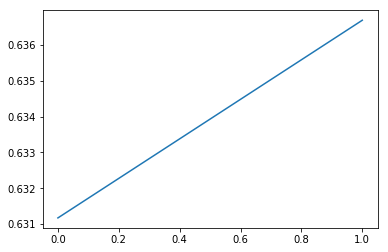

In [26]:
from matplotlib import pyplot as plt 
plt.plot(loss_history)